In [12]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data frames
df_train = pd.read_csv('/kaggle/input/dataframes-bal/train_bal.csv')
df_val = pd.read_csv('/kaggle/input/dataframes-bal/val_bal.csv')
df_test = pd.read_csv('/kaggle/input/dataframes-bal/test_bal.csv')

# load visual embeddings
with open('/kaggle/input/v-emb-bal/v_embeds_train.pkl', 'rb') as f:
    v_embeds_train = pickle.load(f) 
    
with open('/kaggle/input/v-emb-bal/v_embeds_val.pkl', 'rb') as f:
    v_embeds_val = pickle.load(f) 
    
with open('/kaggle/input/v-emb-bal/v_embeds_test.pkl', 'rb') as f:
    v_embeds_test = pickle.load(f) 

In [4]:
print(len(v_embeds_train))
print(v_embeds_train[0].shape)
stacked_tensor = torch.stack(v_embeds_train, dim=0)

print(stacked_tensor.shape)

1602
torch.Size([100, 1024])
torch.Size([1602, 100, 1024])


In [5]:
# stack visual features 
X_train = torch.stack(v_embeds_train, dim=0).cpu().numpy()
X_val = torch.stack(v_embeds_val, dim=0).cpu().numpy()
X_test = torch.stack(v_embeds_test, dim=0).cpu().numpy()
print(X_train.shape, X_val.shape, X_test.shape)

(1602, 100, 1024) (89, 100, 1024) (89, 100, 1024)


In [6]:
# convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['AUTHOR'])
y_val = label_encoder.transform(df_val['AUTHOR'])
y_test = label_encoder.transform(df_test['AUTHOR'])

painter_mapping = list(label_encoder.classes_) # get new label numbers and painters (for confusion matrix legend)
print(painter_mapping)

['CRANACH, Lucas the Elder', 'GIOTTO di Bondone', 'GOGH, Vincent van', 'GRECO, El', 'REMBRANDT Harmenszoon van Rijn', 'RUBENS, Peter Paul', 'TIEPOLO, Giovanni Battista', 'TIZIANO Vecellio', 'UNKNOWN MASTER, Italian', 'VERONESE, Paolo']


In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 1024)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

optim = tf.keras.optimizers.Adam(learning_rate=1e-4) # decreased learning rate from 1e-5 to 1e-4
#loss_func = tf.keras.losses.CategoricalCrossentropy() # BERT uses this! Maybe change labels to one hot encoding?

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


# evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/20
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0924 - loss: 38.2711

W0000 00:00:1716397574.845920     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1185 - loss: 33.6048

W0000 00:00:1716397576.124367     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1197 - loss: 33.2912 - val_accuracy: 0.1798 - val_loss: 7.8982
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4113 - loss: 4.0243 - val_accuracy: 0.1910 - val_loss: 6.6636
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6005 - loss: 2.1630 - val_accuracy: 0.2135 - val_loss: 9.7218
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6293 - loss: 2.1158 - val_accuracy: 0.1236 - val_loss: 11.9868
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7225 - loss: 1.5117 - val_accuracy: 0.2697 - val_loss: 7.5201
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1814 - loss: 6.3129  
Validation Loss: 6.663568496704102, Validation Accuracy: 0.1910112351179123
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3321 - loss: 4.6905 
Test Loss: 4.700058937072754, Test Accuracy: 0.3595505654811859


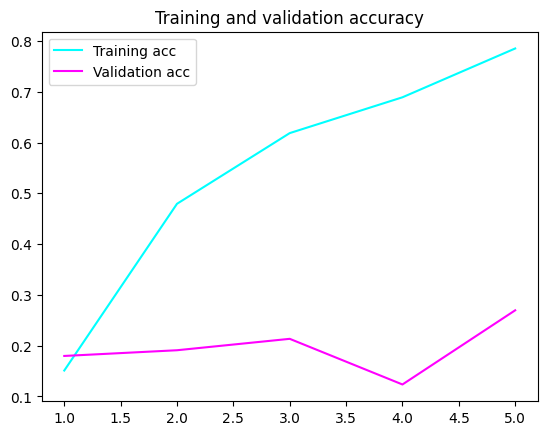

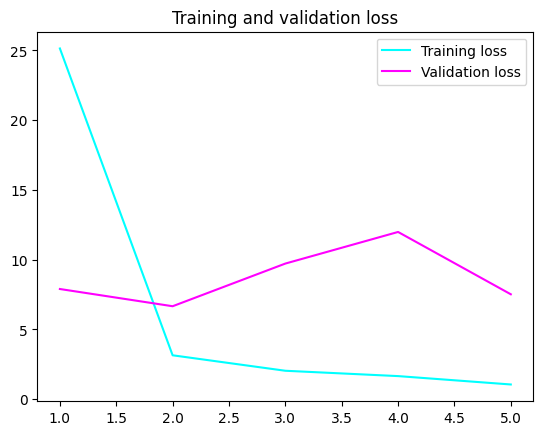

In [21]:
# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The model is clearly overfitting (plateau in validation accuracy and loss while the training loss decreases to 0 and the training accuracy reaches 1.0). The data size is relatively small and model might be too complex for this amount of data.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


W0000 00:00:1716397589.912107     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


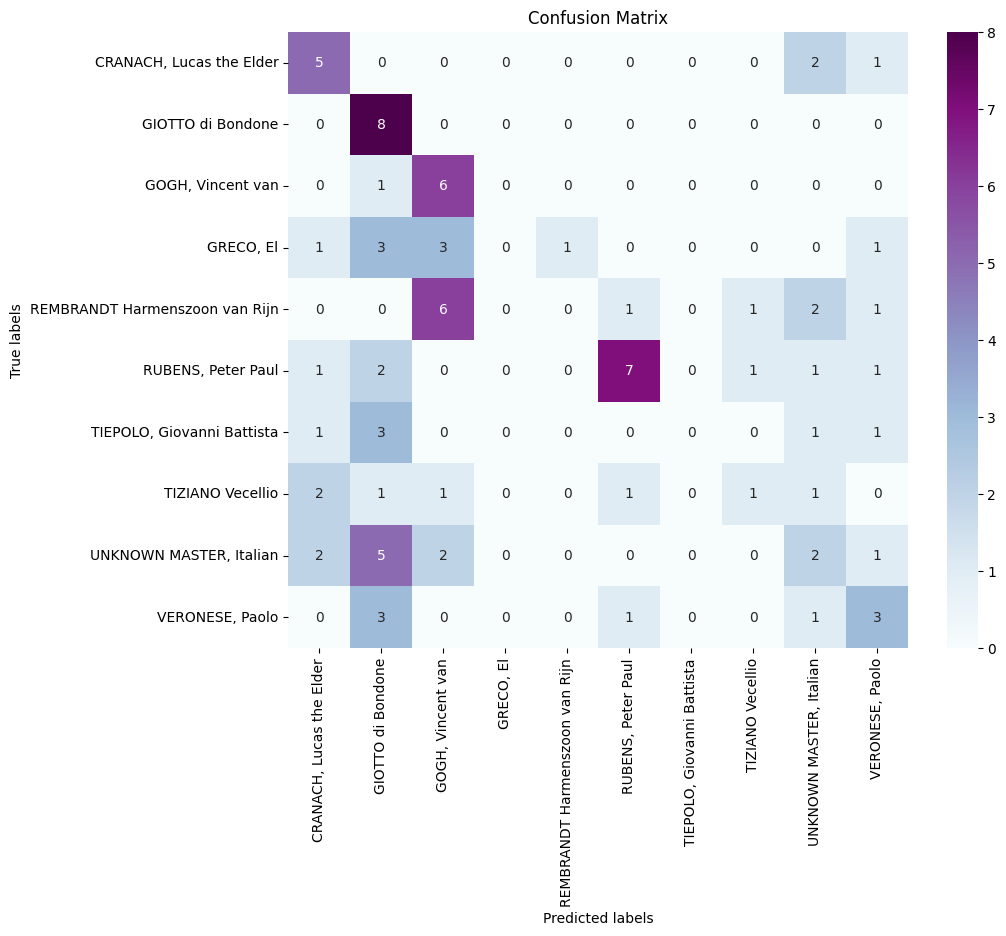

In [22]:
# predictions on test set
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Experiment 1
Test to prevent model from overfitting: Add Dropout Layers and BatchNormalization:

Epoch 1/50
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1233 - loss: 3.4542

W0000 00:00:1716397020.874377     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.1407 - loss: 3.3078

W0000 00:00:1716397025.531186     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.1417 - loss: 3.3002 - val_accuracy: 0.0787 - val_loss: 10.6669
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2715 - loss: 2.4051 - val_accuracy: 0.1461 - val_loss: 5.0469
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3120 - loss: 2.1162 - val_accuracy: 0.1685 - val_loss: 3.8385
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3832 - loss: 1.8505 - val_accuracy: 0.3146 - val_loss: 2.1459
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4619 - loss: 1.5436 - val_accuracy: 0.2360 - val_loss: 2.2085
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5265 - loss: 1.3925 - val_accuracy: 0.2584 - val_loss: 2.0916
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5629 - loss: 1.3026 - val_accuracy: 0.3258 - val_loss: 1.9837
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5805 - loss: 1.1828 - val_accuracy: 0.3371 - val_loss:

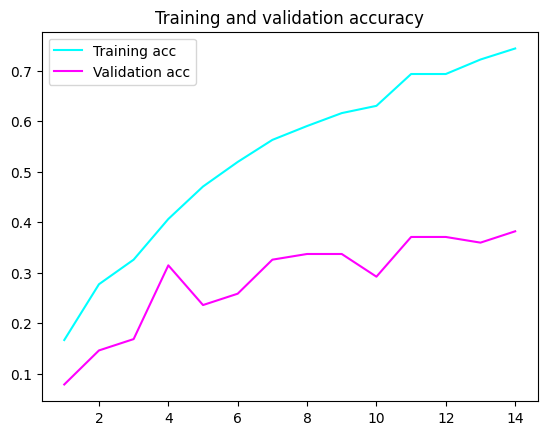

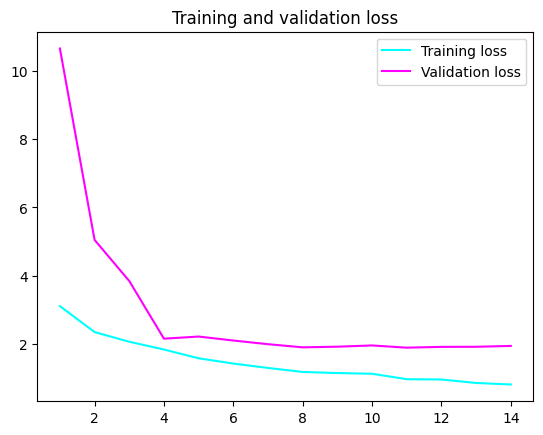

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 1024)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step

W0000 00:00:1716397098.155780     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


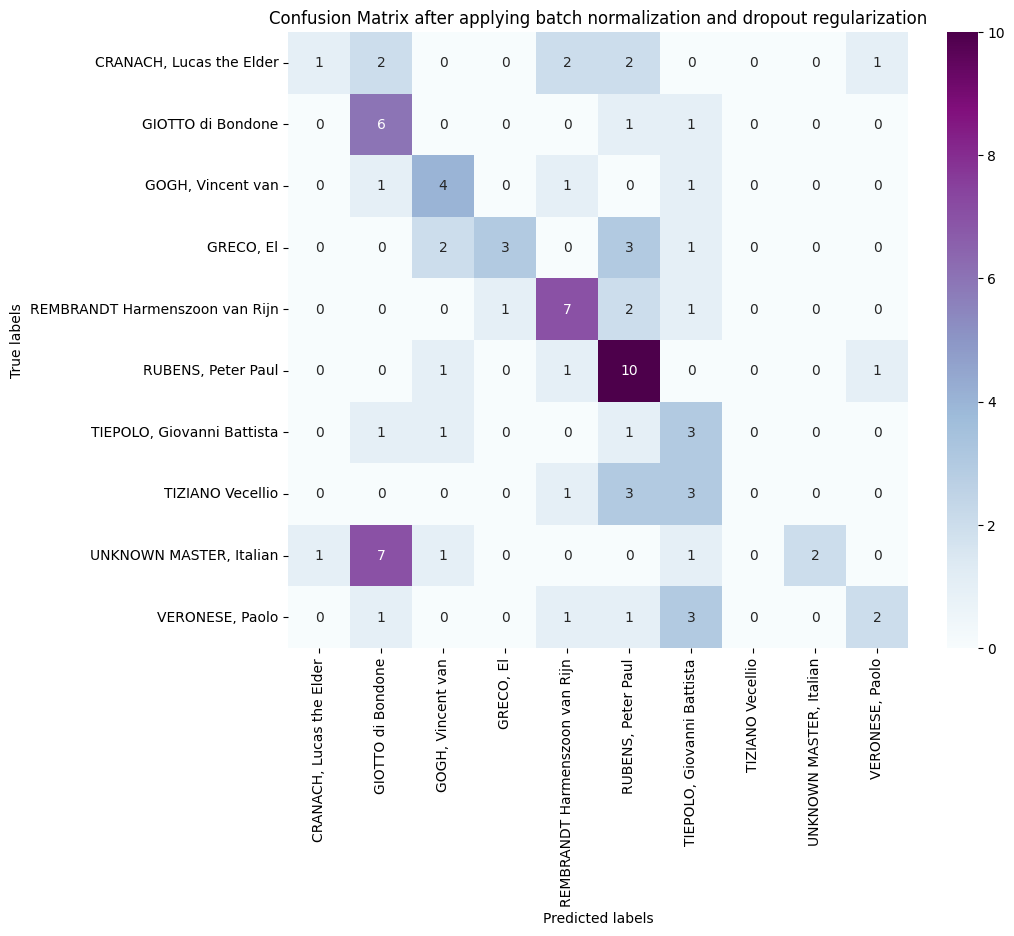

In [15]:
# confusion matrix after applying batch normalization and dropout regularization

# predictions on test set
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after applying batch normalization and dropout regularization')
plt.show()

## Experiment 2
Use a convolution neural network to enhance model's performance (QUOTE):

Epoch 1/20
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1013 - loss: 2.6460

W0000 00:00:1716397470.934093     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1231 - loss: 2.4812

W0000 00:00:1716397473.318995     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.1243 - loss: 2.4748 - val_accuracy: 0.1573 - val_loss: 2.1054
Epoch 2/20
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2058 - loss: 2.0858

W0000 00:00:1716397473.793331     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2111 - loss: 2.0759 - val_accuracy: 0.2472 - val_loss: 2.0247
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3009 - loss: 1.8972 - val_accuracy: 0.2472 - val_loss: 2.1447
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3443 - loss: 1.7717 - val_accuracy: 0.2584 - val_loss: 1.9676
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3858 - loss: 1.6786 - val_accuracy: 0.3371 - val_loss: 1.8743
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4368 - loss: 1.5630 - val_accuracy: 0.3371 - val_loss: 1.9781
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4170 - loss: 1.5728 - val_accuracy: 0.2921 - val_loss: 1.9268
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4350 - loss: 1.6039 - val_accuracy: 0.3034 - val_loss: 1.8757
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3053 - loss: 1.9248  
Validation Loss: 1.8743046522140503, Validation A

W0000 00:00:1716397478.063128     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 1.6573917865753174, Test Accuracy: 0.4157303273677826


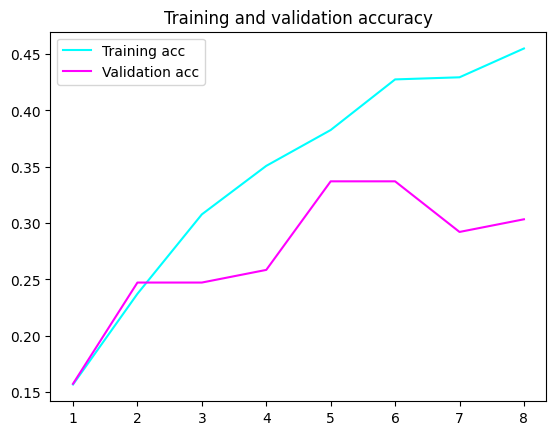

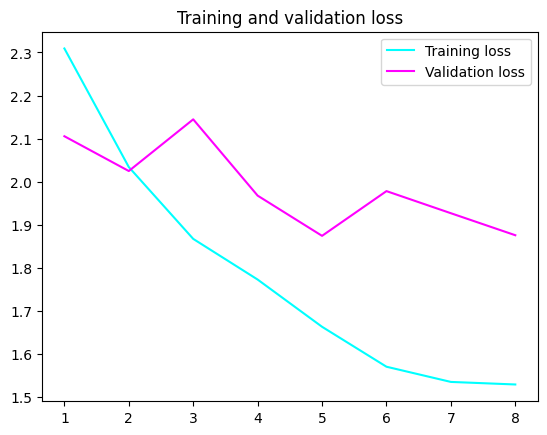

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential

# Define the model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(100, 1024)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step

W0000 00:00:1716397479.424325     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step


W0000 00:00:1716397479.797345     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


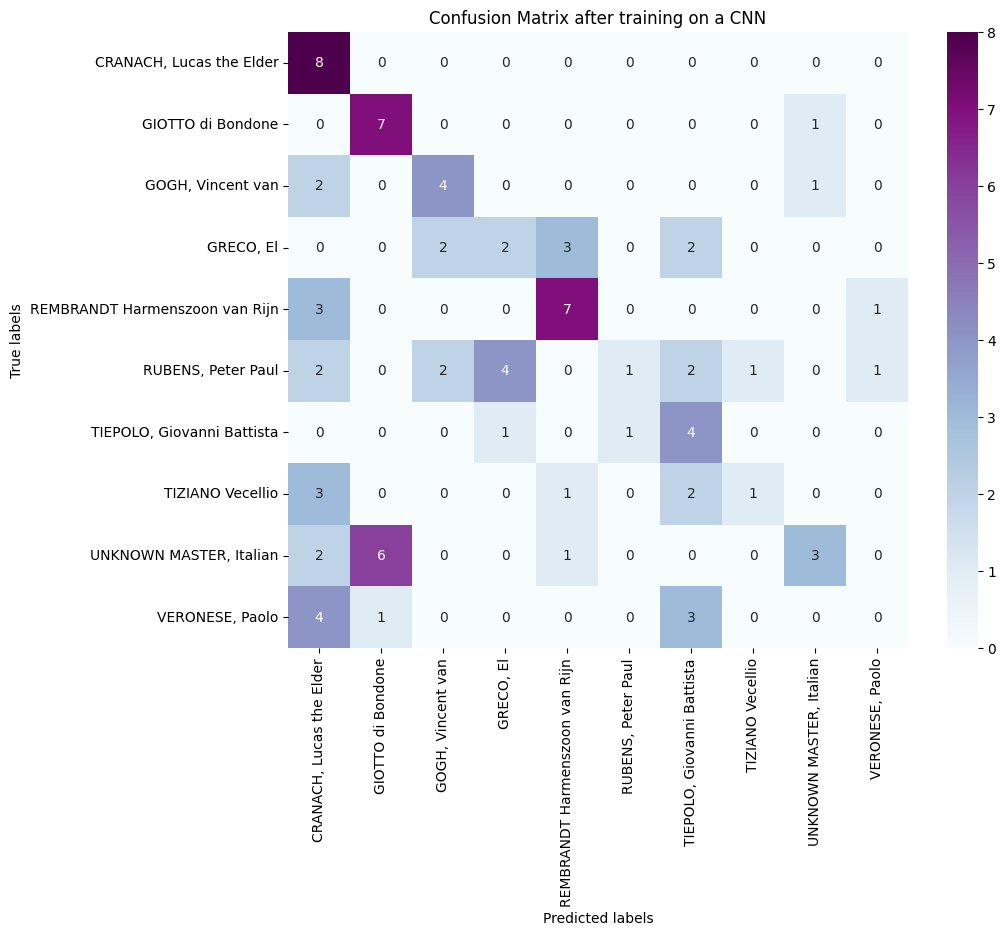

In [18]:
# confusion matrix after applying batch normalization and dropout regularization

# predictions on test set
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after training on a CNN')
plt.show()